In [30]:
import pandas as pd 
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns


In [56]:
# Replace 'dataset-name' with the actual dataset name from Kaggle
dataset_name = 'claytonmiller/occupant-presence-and-actions-in-office-building'

# Download the dataset to the current directory
kaggle.api.dataset_download_files(dataset_name, unzip=True)

# Replace 'dataset_filename.csv' with the actual filename of your dataset
df = pd.read_csv('01_occ.csv')
# Display the first few rows of the dataset
print(df.head())

# Get a summary of the dataset (data types, missing values, etc.)
print(df.info())



  timestamp [dd/mm/yyyy HH:MM]  ki [0:vacant 1:occupied]  \
0             01/01/2013 00:00                       0.0   
1             01/01/2013 00:15                       0.0   
2             01/01/2013 00:30                       0.0   
3             01/01/2013 00:45                       0.0   
4             01/01/2013 01:00                       0.0   

   o1_1 [0:vacant 1:occupied]  o1_2 [0:vacant 1:occupied]  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   o1_3 [0:vacant 1:occupied]  o1_4 [0:vacant 1:occupied]  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.

In [57]:
# Descriptive statistics for numerical columns
print(df.describe())
print(df.info())


       ki [0:vacant 1:occupied]  o1_1 [0:vacant 1:occupied]  \
count              35040.000000                35040.000000   
mean                   0.085819                    0.131502   
std                    0.207412                    0.291381   
min                    0.000000                    0.000000   
25%                    0.000000                    0.000000   
50%                    0.000000                    0.000000   
75%                    0.000000                    0.000000   
max                    1.000000                    1.000000   

       o1_2 [0:vacant 1:occupied]  o1_3 [0:vacant 1:occupied]  \
count                35040.000000                35040.000000   
mean                     0.158966                    0.161984   
std                      0.324744                    0.336210   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000000         

In [33]:
# Create an empty DataFrame to store the rates
rate_df = pd.DataFrame(columns=['Column', 'Rate'])

# Calculate and add the rates for each binary column to the rate DataFrame
for column in df.columns:
    if df[column].dtype == 'float64':
        rate = df[column].mean() * 100  # Calculate the rate and convert to percentage
        rate_df = pd.concat([rate_df, pd.DataFrame({'Column': [column], 'Rate': [rate]})], ignore_index=True)
        
# Format the rate column to display percentages with one decimal place
rate_df['Rate'] = rate_df['Rate'].map('{:.2f}%'.format)

# save it for use in floor_plan_ploting  : 
rate_df.to_csv('rate_df.csv', index=False)  # Save DataFrame to a CSV file

# Display the rate DataFrame with percentages
print(rate_df)

                       Column    Rate
0    ki [0:vacant 1:occupied]   8.58%
1  o1_1 [0:vacant 1:occupied]  13.15%
2  o1_2 [0:vacant 1:occupied]  15.90%
3  o1_3 [0:vacant 1:occupied]  16.20%
4  o1_4 [0:vacant 1:occupied]  19.01%
5  o1_5 [0:vacant 1:occupied]  16.94%
6    o2 [0:vacant 1:occupied]  16.94%
7    o3 [0:vacant 1:occupied]  15.28%
8    o4 [0:vacant 1:occupied]  12.92%


In [34]:
# Convert the timestamp column to a proper datetime format (assuming the column name is 'timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp [dd/mm/yyyy HH:MM]'])

# Extract day and hour information from the 'timestamp' column
# working_hours_df['day'] = df['timestamp'].dt.day
df['minute'] = df['timestamp'].dt.minute
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
# working_hours_df['hour'] = df['timestamp'].dt.hour

# Filter the DataFrame to include only rows during working hours (8:00 AM to 6:00 PM)
working_hours_df = df[(df['timestamp'].dt.hour >= 8) & (df['timestamp'].dt.hour < 18)]

# Create an empty DataFrame to store the rates
rate_df = pd.DataFrame(columns=['Column', 'Rate'])

# Calculate and add the rates for each binary column to the rate DataFrame
for column in working_hours_df.columns:
    if working_hours_df[column].dtype == 'float64':
        rate = working_hours_df[column].mean() * 100  # Calculate the rate and convert to percentage
        rate_df = pd.concat([rate_df, pd.DataFrame({'Column': [column], 'Rate': [rate]})], ignore_index=True)

# Format the rate column to display percentages with one decimal place
rate_df['Rate'] = rate_df['Rate'].map('{:.1f}%'.format)

# Display the rate DataFrame with percentages
print(rate_df)


                       Column   Rate
0    ki [0:vacant 1:occupied]  18.9%
1  o1_1 [0:vacant 1:occupied]  29.1%
2  o1_2 [0:vacant 1:occupied]  32.1%
3  o1_3 [0:vacant 1:occupied]  31.0%
4  o1_4 [0:vacant 1:occupied]  37.5%
5  o1_5 [0:vacant 1:occupied]  37.1%
6    o2 [0:vacant 1:occupied]  37.1%
7    o3 [0:vacant 1:occupied]  33.7%
8    o4 [0:vacant 1:occupied]  28.0%


In [35]:
import numpy as np
import holidays


# Identify weekends and public holidays in the US
us_holidays = holidays.US(years=int(df['timestamp'].dt.year.min()), observed=True)
df['is_weekend'] = df['timestamp'].dt.dayofweek.isin([5, 6])  # 5=Saturday, 6=Sunday
df['is_public_holiday'] = df['timestamp'].dt.date.isin(us_holidays)

# Filter out weekends and public holidays from the analysis
working_days_df = df[~(df['is_weekend'] | df['is_public_holiday'])]


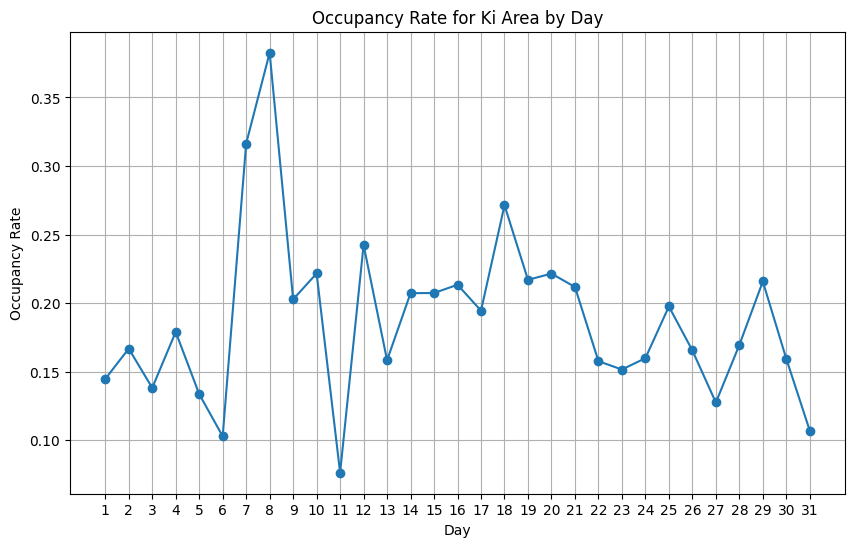

In [36]:
# Group by day and calculate the mean occupancy rate for 'ki'
occupancy_by_day = working_hours_df.groupby('day')['ki [0:vacant 1:occupied]'].mean()

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(occupancy_by_day.index, occupancy_by_day.values, marker='o', linestyle='-')
plt.xlabel('Day')
plt.ylabel('Occupancy Rate')
plt.title('Occupancy Rate for Ki Area by Day')
plt.xticks(occupancy_by_day.index)
plt.grid(True)
plt.show()

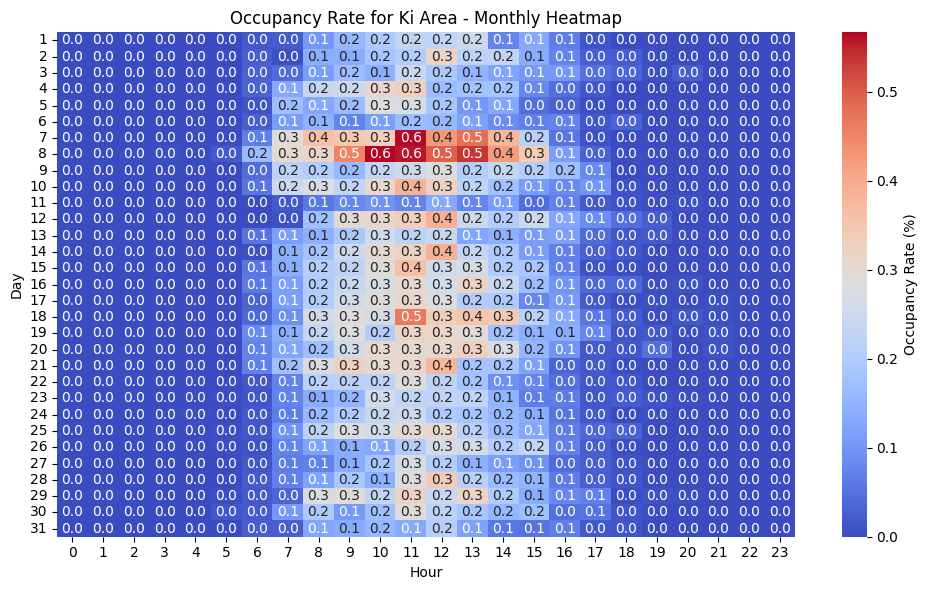

In [37]:

# Use pivot_table() to aggregate the occupancy rate for 'ki' area by day and hour
heatmap_data = df.pivot_table(index='day', columns='hour', values='ki [0:vacant 1:occupied]', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': 'Occupancy Rate (%)'})
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Occupancy Rate for Ki Area - Monthly Heatmap')
plt.tight_layout()
plt.show()



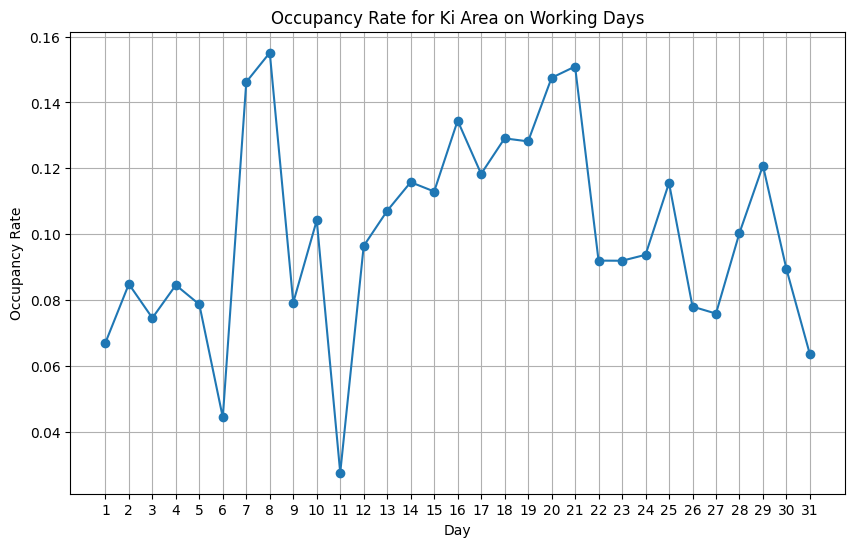

In [38]:
# Calculate the mean occupancy rate for 'ki' area for each working day
occupancy_by_day = working_days_df.groupby('day')['ki [0:vacant 1:occupied]'].mean()

# Create the line chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(occupancy_by_day.index, occupancy_by_day.values, marker='o', linestyle='-')
plt.xlabel('Day')
plt.ylabel('Occupancy Rate')
plt.title('Occupancy Rate for Ki Area on Working Days')
plt.xticks(occupancy_by_day.index)
plt.grid(True)
plt.show()


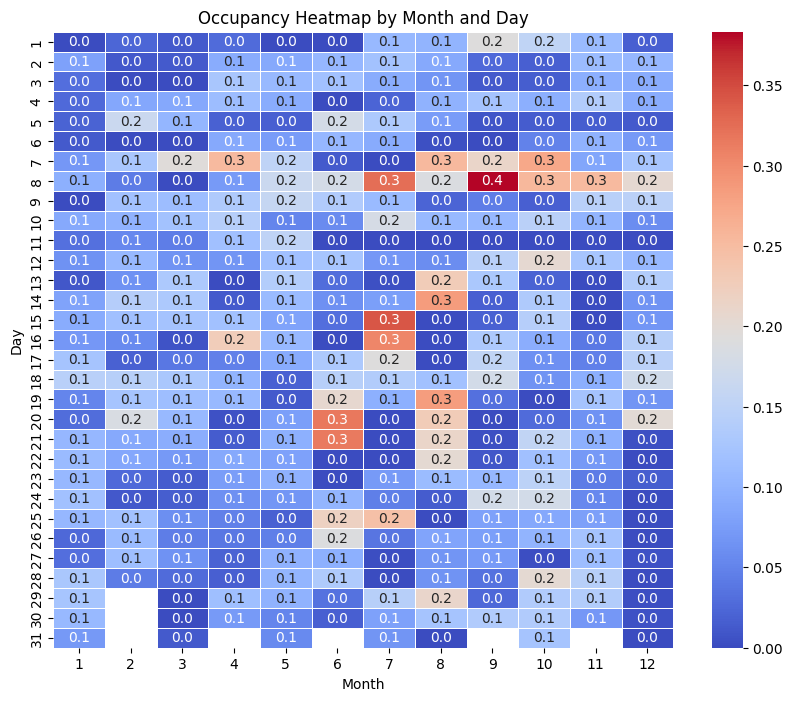

In [39]:
# Occupancy Trends Over Time:
# Plot the occupancy data over time to visualize how the number of occupants in the office building changes throughout the day or week. 
# This can help identify peak occupancy hours, trends, and patterns.
# Calculate the total occupancy count for each timestamp


# Pivot the DataFrame to create a heatmap
heatmap_data = df.pivot_table(index='day', columns='month', values='ki [0:vacant 1:occupied]', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.1f', linewidths=0.5)
plt.xlabel('Month')
plt.ylabel('Day')
plt.title('Occupancy Heatmap by Month and Day')
plt.show()


C:\Users\ali\AppData\Local\Temp\ipykernel_17148\2427610216.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_days_df['occupancy_rate'] = working_days_df[room_columns].mean(axis=1)


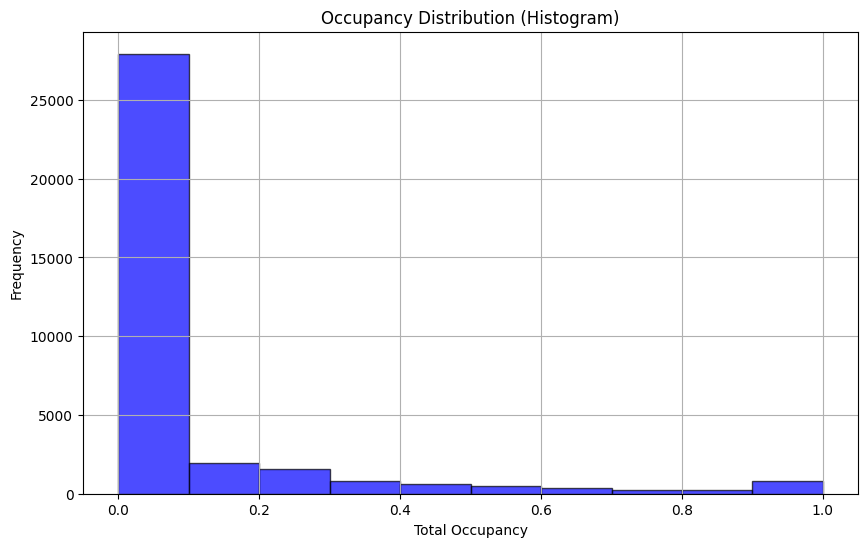

C:\Users\ali\AppData\Local\Temp\ipykernel_17148\2427610216.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['ki [0:vacant 1:occupied]'], color='blue', shade=True)


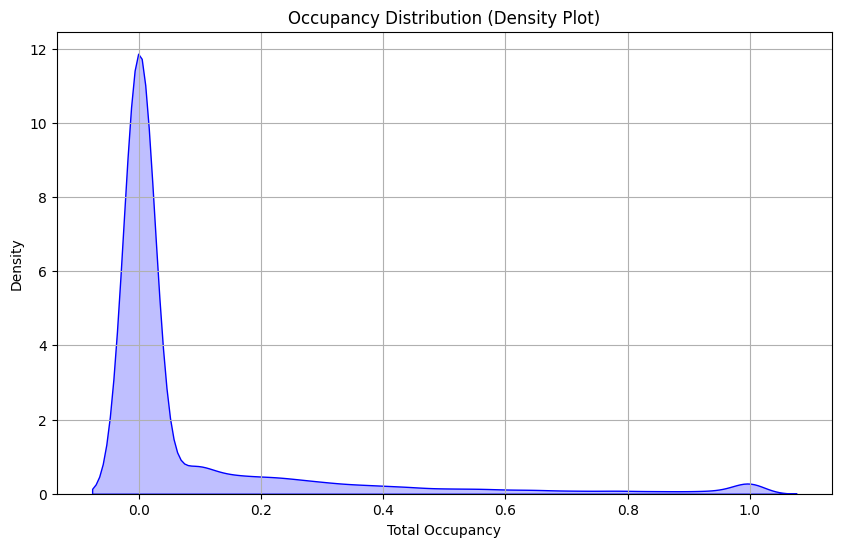

In [40]:

# Calculate the total occupancy count for each timestamp
# df.drop(df.columns[[1,5:]], axis=1, inplace=True)
# df['total_occupancy'] = df.drop(df.columns[[1,5]], axis=1, inplace=True).sum(axis=1)

#Select the rooms coccupancy : 
room_columns = ['ki [0:vacant 1:occupied]', 'o1_1 [0:vacant 1:occupied]','o1_3 [0:vacant 1:occupied]', 'o1_5 [0:vacant 1:occupied]', 'o2 [0:vacant 1:occupied]','o3 [0:vacant 1:occupied]', 'o4 [0:vacant 1:occupied]']

# Calculate the occupancy rate for each room
df['occupancy_rate'] = df[room_columns].mean(axis=1)

# Calculate the occupancy rate for each room
working_days_df['occupancy_rate'] = working_days_df[room_columns].mean(axis=1)
working_days_df

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['ki [0:vacant 1:occupied]'], bins=10, edgecolor='black', color='blue', alpha=0.7)
plt.xlabel('Total Occupancy')
plt.ylabel('Frequency')
plt.title('Occupancy Distribution (Histogram)')
plt.grid(True)
plt.show()

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['ki [0:vacant 1:occupied]'], color='blue', shade=True)
plt.xlabel('Total Occupancy')
plt.ylabel('Density')
plt.title('Occupancy Distribution (Density Plot)')
plt.grid(True)
plt.show()

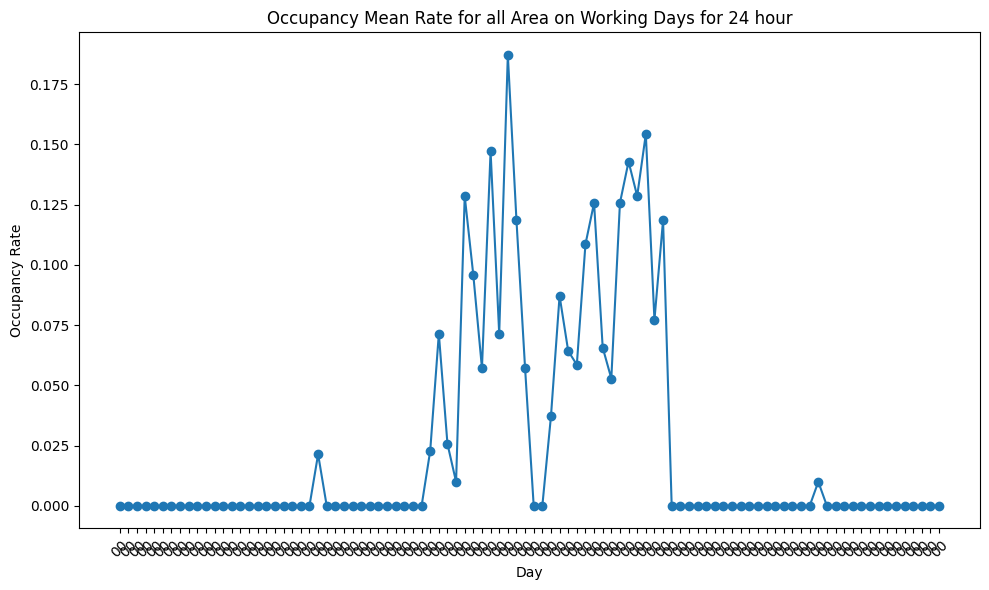

In [41]:
working_days_df_for_24h = working_days_df.head(4*24)

# Create the line chart
# import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(10, 6))
plt.plot(working_days_df_for_24h['timestamp [dd/mm/yyyy HH:MM]'], working_days_df_for_24h['occupancy_rate'], marker='o', linestyle='-')
plt.xlabel('Day')
plt.ylabel('Occupancy Rate')
plt.title('Occupancy Mean Rate for all Area on Working Days for 24 hour')

# plt.xticks(working_days_df_for_24h['timestamp'])

# Format the x-axis labels to display only minutes and hours
date_format = mdates.DateFormatter('%M')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the font size for x-axis labels to make it clearer
plt.xticks(fontsize=10, rotation=45)

# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()




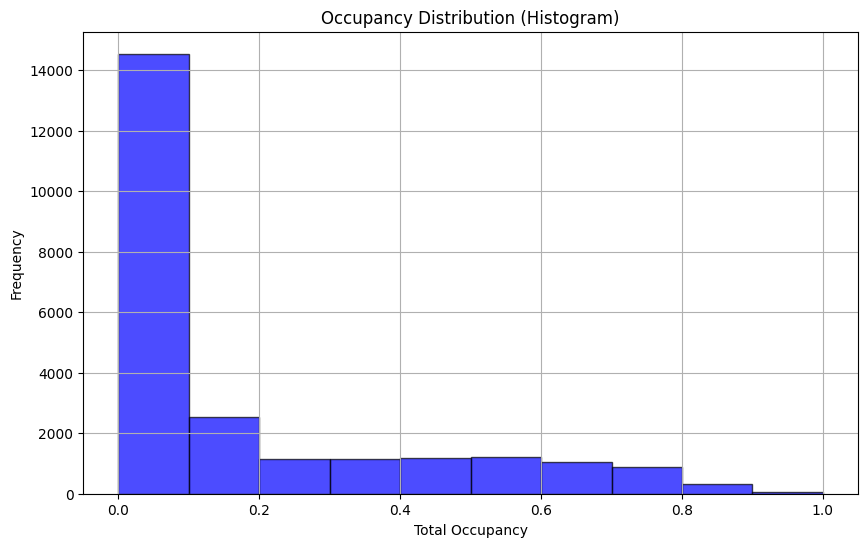

C:\Users\ali\AppData\Local\Temp\ipykernel_17148\2374072959.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(working_days_df['occupancy_rate'], color='blue', shade=True)


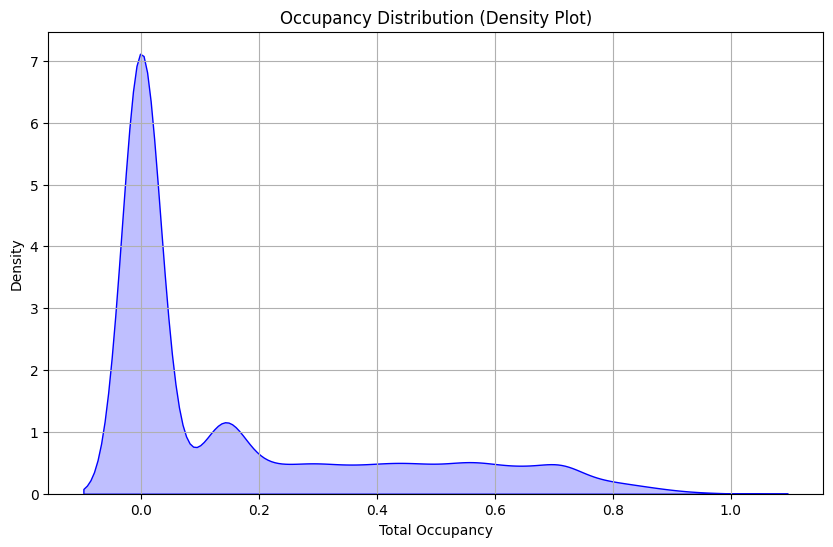

In [42]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(working_days_df['occupancy_rate'], bins=10, edgecolor='black', color='blue', alpha=0.7)
plt.xlabel('Total Occupancy')
plt.ylabel('Frequency')
plt.title('Occupancy Distribution (Histogram)')
plt.grid(True)
plt.show()

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(working_days_df['occupancy_rate'], color='blue', shade=True)
plt.xlabel('Total Occupancy')
plt.ylabel('Density')
plt.title('Occupancy Distribution (Density Plot)')
plt.grid(True)
plt.show()

C:\Users\ali\AppData\Local\Temp\ipykernel_17148\2118129606.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_days_df_for_24h[mean_by_day_column] = working_days_df.groupby(working_days_df_for_24h['timestamp'].dt.date)[room_column].transform('mean')
C:\Users\ali\AppData\Local\Temp\ipykernel_17148\2118129606.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_days_df_for_24h[mean_by_day_column] = working_days_df.groupby(working_days_df_for_24h['timestamp'].dt.date)[room_column].transform('mea

            ki [0:vacant 1:occupied]  o1_1 [0:vacant 1:occupied]  \
timestamp                                                          
2013-01-02                  0.080833                    0.103854   
2013-01-03                  0.030625                    0.018021   
2013-01-04                  0.026771                    0.032396   
2013-01-07                  0.069792                    0.112812   
2013-01-08                  0.095938                    0.113229   
2013-01-09                  0.000729                    0.000000   
2013-01-10                  0.089271                    0.235417   
2013-01-11                  0.032708                    0.071250   
2013-01-14                  0.082083                    0.110521   
2013-01-15                  0.092187                    0.209271   

            o1_3 [0:vacant 1:occupied]  o1_5 [0:vacant 1:occupied]  \
timestamp                                                            
2013-01-02                    0.187083     

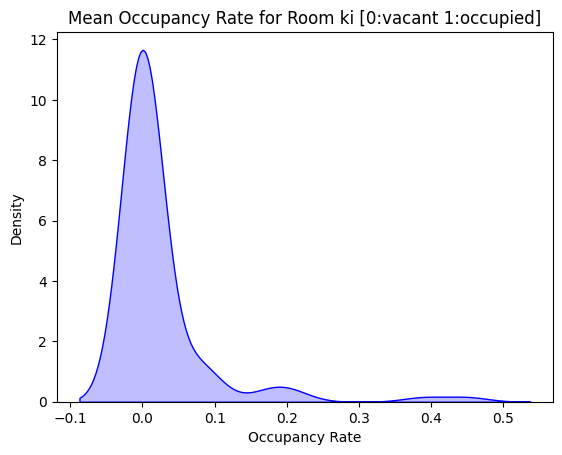

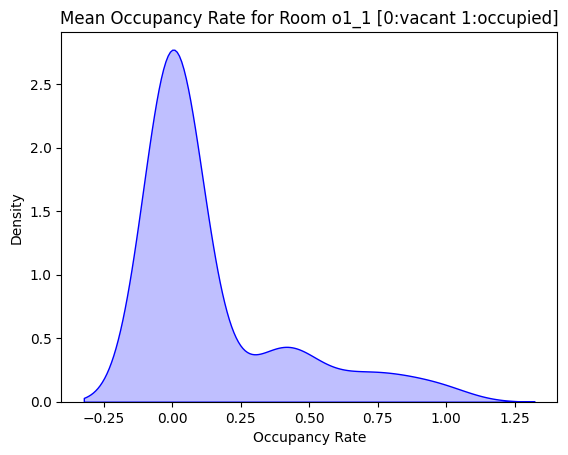

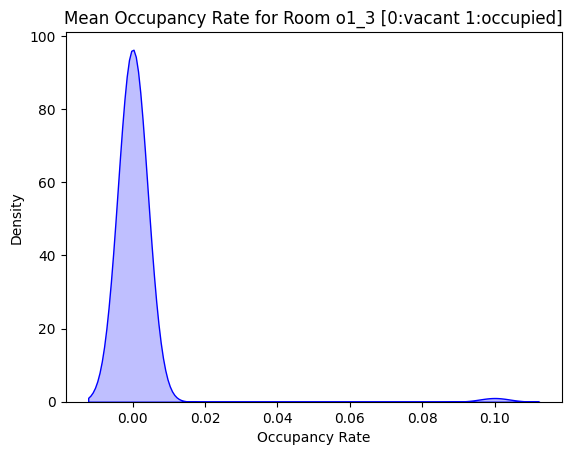

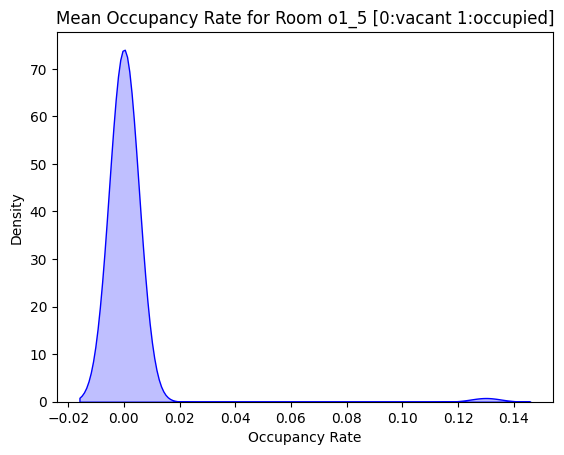

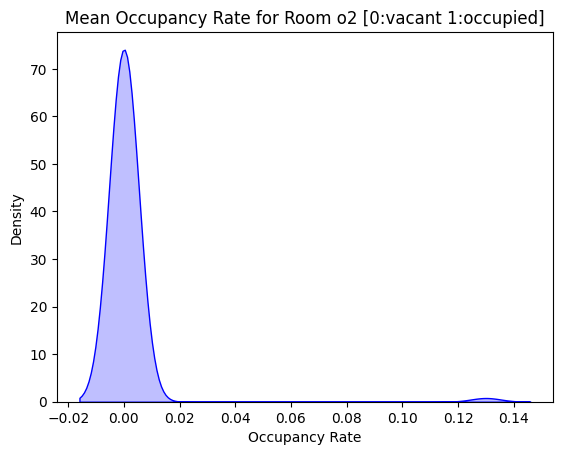

C:\Users\ali\AppData\Local\Temp\ipykernel_17148\2118129606.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(working_days_df_for_24h[room_column], color='blue', fill=True)  # This line may cause the warning, but it's not related to the previous issue


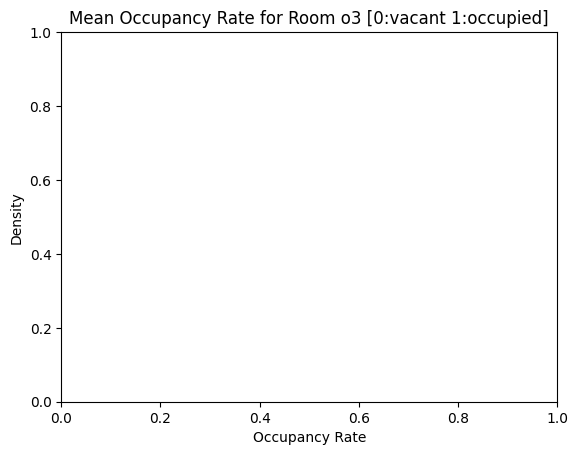

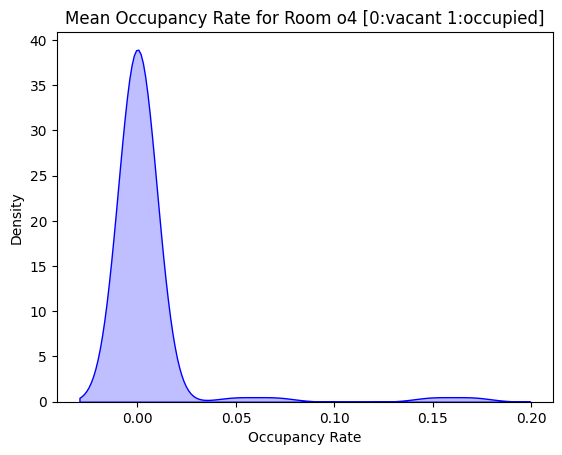

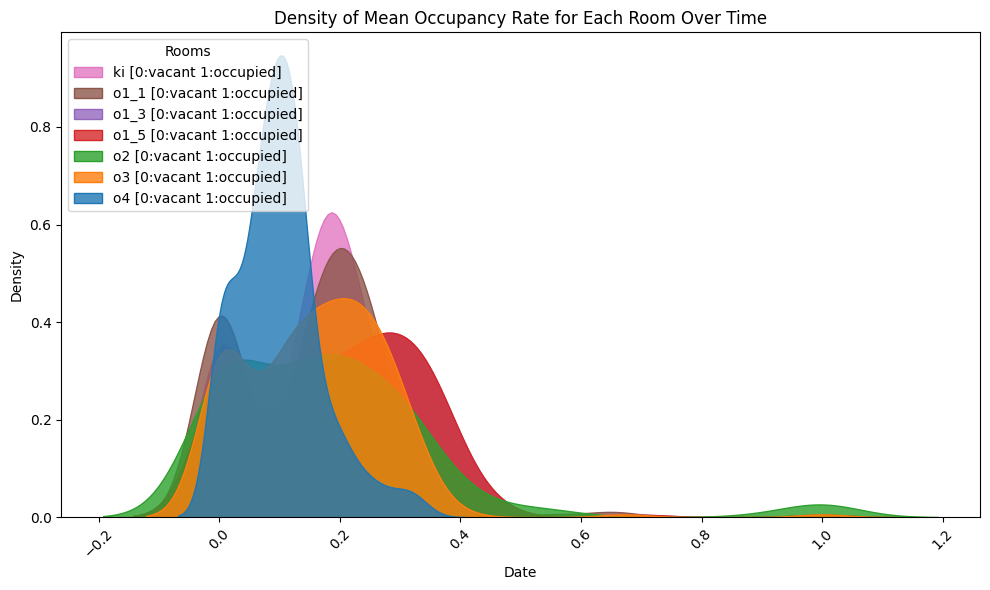

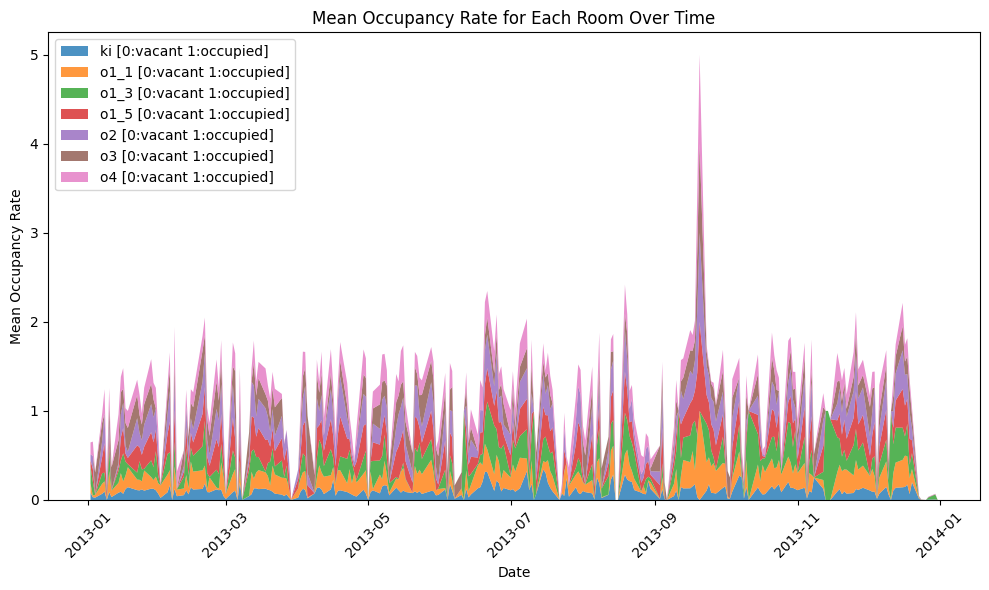

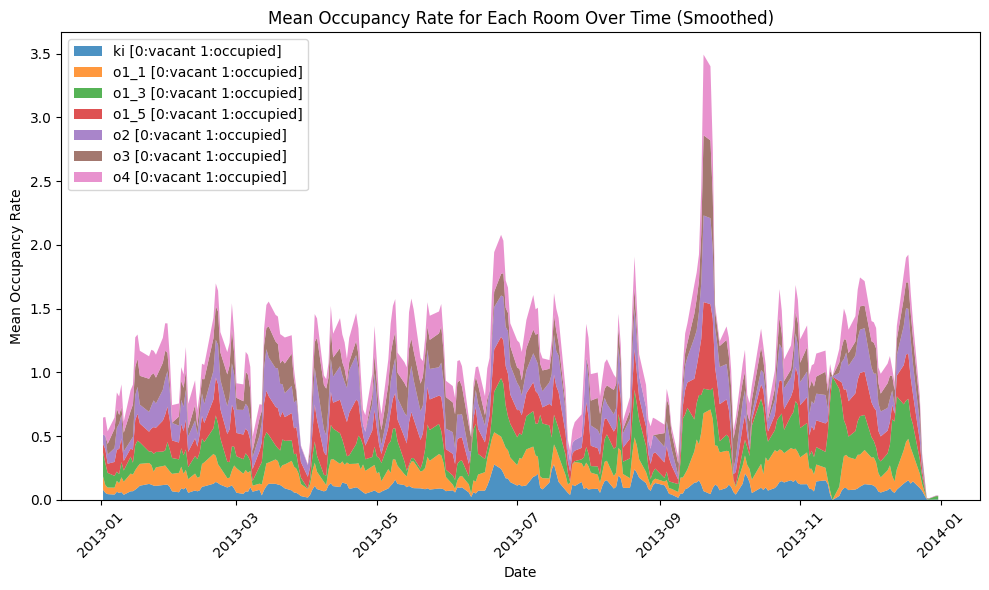

In [43]:
# Calculate the mean occupancy rate by day
for room_column in room_columns:
    mean_by_day_column = room_column + '_mean_day'
    working_days_df_for_24h[mean_by_day_column] = working_days_df.groupby(working_days_df_for_24h['timestamp'].dt.date)[room_column].transform('mean')
    # Group by day and calculate mean occupancy rate for each room

df_mean_by_day = working_days_df.groupby(df['timestamp'].dt.date)[room_columns].mean()
    
print(df_mean_by_day.head(10))
# Plot the mean occupancy rate for each room
for room_column in room_columns:
    plt.figure()
    sns.kdeplot(working_days_df_for_24h[room_column], color='blue', fill=True)  # This line may cause the warning, but it's not related to the previous issue
    plt.title(f"Mean Occupancy Rate for Room {room_column}")
    plt.xlabel("Occupancy Rate")
    plt.ylabel("Density")
    plt.show()

# Create the density plot for all rooms in one plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_mean_by_day[room_columns], fill=True, palette='tab10', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Density')
plt.title('Density of Mean Occupancy Rate for Each Room Over Time')
plt.legend(title='Rooms', labels=room_columns, loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create the streamgraph plot
plt.figure(figsize=(10, 6))
plt.stackplot(df_mean_by_day.index, df_mean_by_day.T, labels=room_columns, alpha=0.8, baseline='zero')
plt.xlabel('Date')
plt.ylabel('Mean Occupancy Rate')
plt.title('Mean Occupancy Rate for Each Room Over Time')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rolling_mean_df = df_mean_by_day.rolling(window=3, min_periods=1, axis=0).mean()

plt.figure(figsize=(10, 6))
plt.stackplot(rolling_mean_df.index, rolling_mean_df.T, labels=room_columns, alpha=0.8, baseline='zero', colors=sns.color_palette('tab10'))
plt.xlabel('Date')
plt.ylabel('Mean Occupancy Rate')
plt.title('Mean Occupancy Rate for Each Room Over Time (Smoothed)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

           ki [0:vacant 1:occupied]  o1_1 [0:vacant 1:occupied]  \
timestamp                                                         
2013-01                    0.086339                    0.122500   
2013-02                    0.094666                    0.148174   
2013-03                    0.076414                    0.141513   
2013-04                    0.091477                    0.165724   
2013-05                    0.093589                    0.157126   
2013-06                    0.127021                    0.154297   
2013-07                    0.131780                    0.154602   
2013-08                    0.131515                    0.120024   
2013-09                    0.085474                    0.263682   
2013-10                    0.118968                    0.191719   
2013-11                    0.090817                    0.170219   
2013-12                    0.075193                    0.139449   

           o1_3 [0:vacant 1:occupied]  o1_5 [0:vacant 1:occup

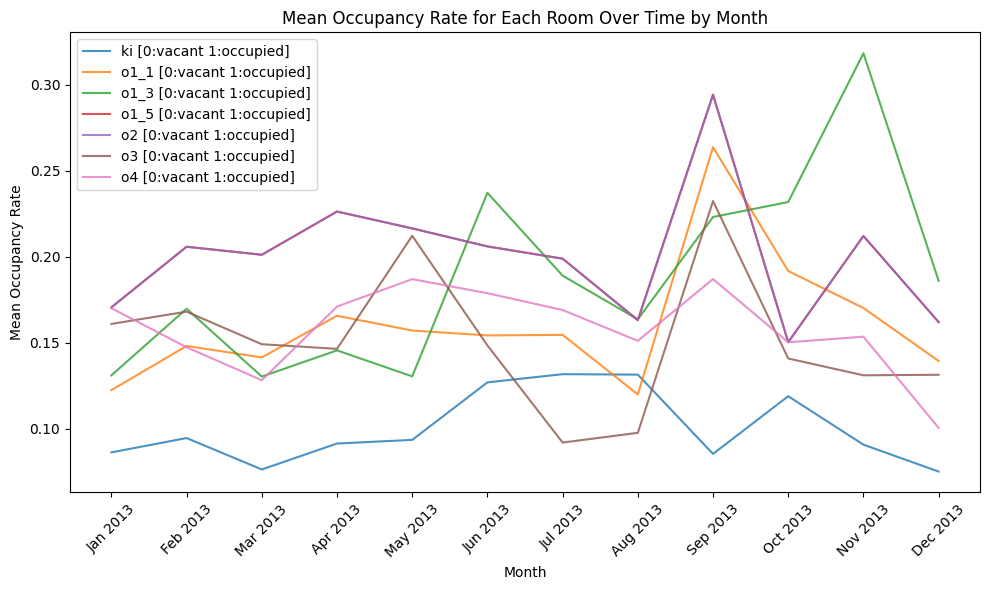

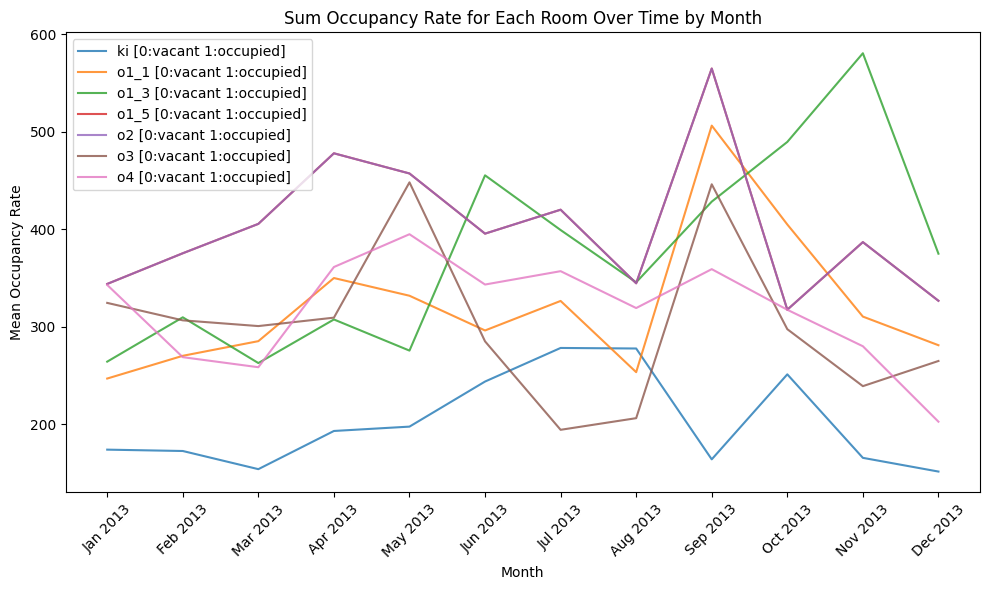

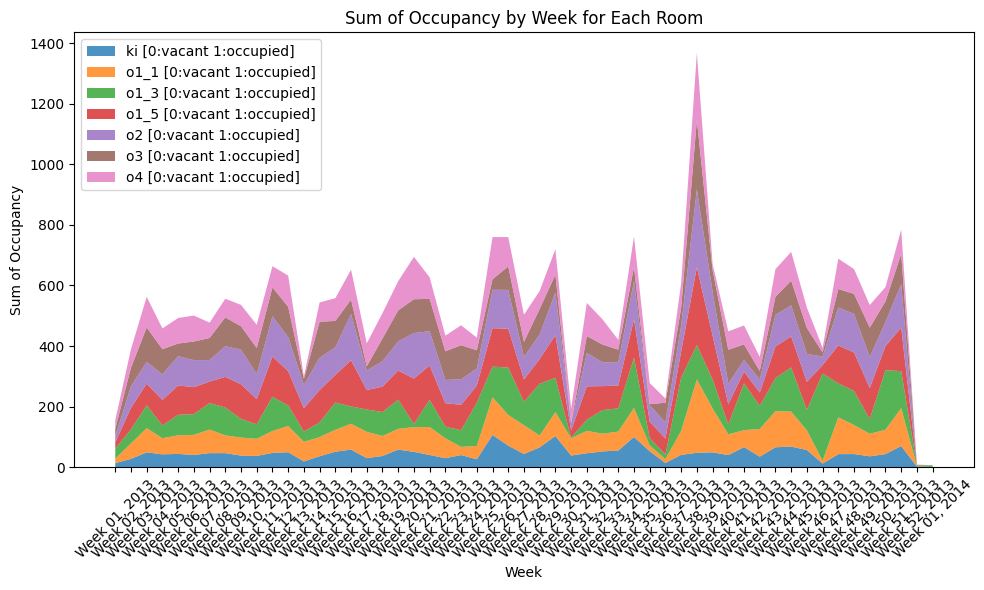

In [44]:

# Group by week and calculate sum of occupancy rate for each room
df_sum_by_week = working_days_df.groupby(df['timestamp'].dt.to_period('W-SUN'))[room_columns].sum()

# Group by month and calculate mean occupancy rate for each room
df_mean_by_month = working_days_df.groupby(df['timestamp'].dt.to_period('M'))[room_columns].mean()
print(df_mean_by_month)

# Group by month and calculate mean occupancy rate for each room
df_sum_by_month = working_days_df.groupby(df['timestamp'].dt.to_period('M'))[room_columns].sum()


# Convert the PeriodIndex to strings (month-year format)
df_sum_by_month.index = df_sum_by_month.index.strftime('%b %Y')

# Convert the PeriodIndex to strings (month-year format)
df_mean_by_month.index = df_mean_by_month.index.strftime('%b %Y')

# Create a plot chart by month
plt.figure(figsize=(10, 6))
for room_column in room_columns:
    plt.plot(df_mean_by_month.index, df_mean_by_month[room_column], label=room_column, alpha=0.8)

plt.xlabel('Month')
plt.ylabel('Mean Occupancy Rate')
plt.title('Mean Occupancy Rate for Each Room Over Time by Month')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 # Create a plot chart by month -sum
plt.figure(figsize=(10, 6))
for room_column in room_columns:
    plt.plot(df_sum_by_month.index, df_sum_by_month[room_column], label=room_column, alpha=0.8)

plt.xlabel('Month')
plt.ylabel('Mean Occupancy Rate')
plt.title('Sum Occupancy Rate for Each Room Over Time by Month')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Convert the PeriodIndex to strings (week-start format)
df_sum_by_week.index = df_sum_by_week.index.strftime('Week %U, %Y')

# Create a stacked area plot for the sum of occupancy by week
plt.figure(figsize=(10, 6))
plt.stackplot(df_sum_by_week.index, df_sum_by_week.T, labels=df_sum_by_week.columns, alpha=0.8)
plt.xlabel('Week')
plt.ylabel('Sum of Occupancy')
plt.title('Sum of Occupancy by Week for Each Room')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [55]:
#  example of using LSTM (Long Short-Term Memory) for forecasting
# the occupancy pattern over time for a specific room in an office building:  the kitechen 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

working_days_df[['timestamp [dd/mm/yyyy HH:MM]' ,  'ki [0:vacant 1:occupied]']]


,timestamp [dd/mm/yyyy HH:MM],ki [0:vacant 1:occupied]
96,02/01/2013 00:00,0.0
97,02/01/2013 00:15,0.0
98,02/01/2013 00:30,0.0
99,02/01/2013 00:45,0.0
100,02/01/2013 01:00,0.0
...,...,...
35035,31/12/2013 22:45,0.0
35036,31/12/2013 23:00,0.0
35037,31/12/2013 23:15,0.0
35038,31/12/2013 23:30,0.0
